In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import cluster
import seaborn as sns

import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:
baskets_df = pd.read_parquet("C:/Users/issam/Downloads/baskets.parquet")
coupons_df = pd.read_parquet("C:/Users/issam/Downloads/coupons.parquet")
prediction_index_df = pd.read_parquet("C:/Users/issam/Downloads/prediction_index.parquet")

In [3]:
import scipy
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
number_shoppers = 100 #reducing data to x some shoppers
tmp = baskets_df.shopper.unique()[:number_shoppers]
df = baskets_df[baskets_df.shopper.isin(tmp)]

coupons = coupons_df[coupons_df.shopper.isin(tmp)]

# Exploring Baskets for Product Categories 

In [5]:
tmp = pd.DataFrame(df.groupby(['week','shopper']).count())
tmp['order_id'] = np.array(range(len(tmp))) ## order_id so that we can find out which produts have been bought together
tmp = tmp.drop(['product','price'],axis = 1)

In [6]:
baskets_co = df.copy()
baskets_co = baskets_co.merge(tmp, on=['week','shopper'], how = 'left')
baskets_co

,week,shopper,product,price,order_id
0,0,0,71,629,0
1,0,0,91,605,0
2,0,0,116,715,0
3,0,0,123,483,0
4,0,0,157,592,0
...,...,...,...,...,...
68655,89,99,82,598,8997
68656,89,99,132,646,8997
68657,89,99,159,667,8997
68658,89,99,199,604,8997


In [7]:
## Function for the co-occurrence sparse matrix
def co_occurrence_sparse(x, variable_basket="basket", variable_product="product"):
    row = x[variable_basket].values
    col = x[variable_product].values
    dim = (x[variable_basket].max()+1, x[variable_product].max()+1)
    
    basket_product_table = scipy.sparse.csr_matrix(
        (np.ones(len(row), dtype=int), (row, col)),
        shape=dim
    )
    co_occurrence_sparse = basket_product_table.T.dot(basket_product_table)
    co_occurrence_dense = co_occurrence_sparse.toarray()
    return co_occurrence_dense

In [8]:
co = pd.DataFrame(co_occurrence_sparse(baskets_co,variable_basket="order_id",variable_product="product"))
co.iloc[:20,:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,167,0,0,0,0,0,0,0,0,0,1,4,2,1,6,0,9,0,1,0
1,0,589,0,0,0,0,0,0,0,0,13,0,4,27,10,9,7,4,3,15
2,0,0,257,0,0,0,0,0,0,0,6,0,1,11,5,1,8,11,5,3
3,0,0,0,84,0,0,0,0,0,0,3,5,0,5,0,1,3,6,0,1
4,0,0,0,0,235,0,0,0,0,0,1,4,0,5,3,2,5,3,0,2
5,0,0,0,0,0,126,0,0,0,0,1,10,2,2,3,1,4,3,2,3
6,0,0,0,0,0,0,236,0,0,0,4,4,0,6,5,5,17,0,1,1
7,0,0,0,0,0,0,0,126,0,0,1,2,3,0,10,1,9,1,1,2
8,0,0,0,0,0,0,0,0,169,0,0,26,1,5,0,4,5,1,0,12
9,0,0,0,0,0,0,0,0,0,189,3,19,4,1,0,2,4,2,0,9


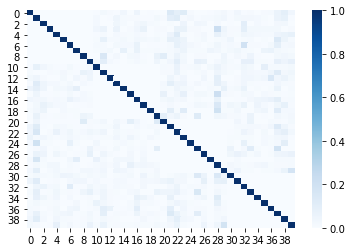

In [9]:
## Obtain percentages of the co-occurrences
co_perc = pd.DataFrame(np.array([co.iloc[x,]/co.iloc[x,x] for x in range(co.shape[0])]))
ax = sns.heatmap(co_perc.iloc[:40,:40], cmap="Blues")

In [10]:
categories = []
for i in np.array(range(25)):
    categories.append(10 * [i])
    
categories = np.array(categories)
categories = categories.flatten()

In [11]:
## To find out the relationship between the categories we reduce the co occurrence matrix so that they only contain the 25 categories 
## instead of the 250 products.

In [12]:
co_cat = pd.DataFrame(co)
co_cat.columns = [categories]
co_cat.index = [categories]
co_cat = co_cat.groupby(level=0, axis=1).sum()
co_cat = co_cat.groupby(level=0, axis=0).sum()
co_cat_perc = pd.DataFrame(np.array([co_cat.iloc[x,]/co_cat.iloc[x,x] for x in range(co_cat.shape[0])])) # for values in %

In [13]:
co_cat_perc.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.000000,0.191919,0.324610,0.297980,0.407713,0.145546,0.431129,0.426079,0.287879,0.289715,...,0.199265,0.398990,0.208907,0.311754,0.516070,0.291093,0.222222,0.352617,0.160698,0.236915
1,0.225094,1.000000,0.308562,0.262789,0.365644,0.149165,0.417878,0.417340,0.292407,0.320948,...,0.264943,0.263866,0.239634,0.252558,0.560582,0.284868,0.217017,0.336564,0.150242,0.311255
2,0.248506,0.201406,1.000000,0.273814,0.382425,0.132162,0.454482,0.417926,0.255185,0.276626,...,0.238313,0.326889,0.209842,0.368366,0.556063,0.323374,0.265026,0.329350,0.155360,0.243234
3,0.259082,0.194810,0.310978,1.000000,0.376447,0.142914,0.451896,0.403194,0.294212,0.308583,...,0.307784,0.347705,0.276647,0.302994,0.517365,0.324950,0.267066,0.385629,0.152096,0.292216
4,0.239547,0.183167,0.293499,0.254384,1.000000,0.105476,0.378743,0.300513,0.261128,0.285676,...,0.229566,0.334233,0.236310,0.275695,0.657405,0.320745,0.259779,0.302131,0.159158,0.305638


* Applying PCA on categories

In [14]:
from sklearn.preprocessing import StandardScaler
X_scaled_cat= StandardScaler().fit_transform(co_cat)
X_scaled_cat[:5]

# We performed the eigendecomposition though Numpy, and it returns a tuple, where the first element represents 
# eingenvalues and the second one represents eigenvectors:
values_cat, vectors_cat = np.linalg.eig(co_cat)
values_cat[:5]

### calculating the percentage of explained Variance per Principal Component

explained_variances_cat = []
for i in range(len(values_cat)):
    explained_variances_cat.append(values_cat[i] / np.sum(values_cat))

print(np.sum(explained_variances_cat), '\n', explained_variances_cat)

1.0 
 [0.36057946386066103, 0.046994317695934026, 0.03854759888062143, 0.03819794378478418, 0.014447157980018567, 0.03403025077370936, 0.01629172691420385, 0.032048171381666254, 0.031094844917247358, 0.02975893908437659, 0.02839422025996442, 0.027642276036461348, 0.027392290648697113, 0.02608154576861431, 0.020124604208144947, 0.025070725454093737, 0.02475909545579709, 0.02086726279701508, 0.0238714573260086, 0.023725683221943888, 0.022943691339921555, 0.02242247532631412, 0.021536415212596707, 0.021932373477971646, 0.021245468193232864]


## Performing PCA

In [15]:
projected_1_cat = X_scaled_cat.dot(vectors_cat.T[0])
projected_2_cat = X_scaled_cat.dot(vectors_cat.T[1])
res_cat = pd.DataFrame(projected_1_cat, columns=['PC1_cat'])
res_cat['PC2_cat'] = projected_2_cat
res_cat['categories'] = np.arange(len(res_cat))
res_cat.head()

,PC1_cat,PC2_cat,categories
0,-2.108304,-0.303152,0
1,-3.257059,0.823144,1
2,0.230494,-0.906202,2
3,-0.672631,-0.731389,3
4,2.858085,2.247147,4


C:\Users\issam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1_cat', ylabel='PC2_cat'>

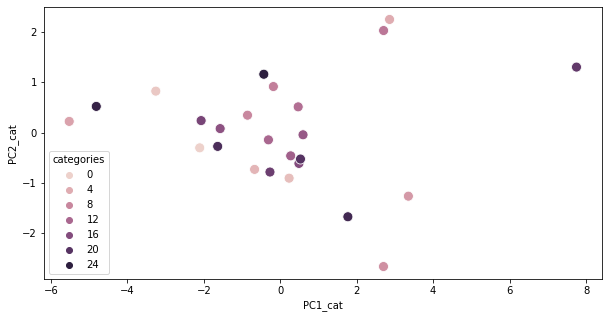

In [16]:
## Plot PCA (two dimensional, with both principal components)
plt.figure(figsize = (10, 5))
sns.scatterplot(res_cat['PC1_cat'], res_cat['PC2_cat'], hue =res_cat['categories'], s=100)

# Feature Engineering

* Simple Feature Creation based on Aggregations

## Categories

In [17]:
categories = []
for i in np.array(range(25)):
    categories.append(10 * [i])
    
categories = np.array(categories)
categories = categories.flatten()

products = np.sort(df['product'].unique())
categories = pd.DataFrame({'product': products,
                          'category': categories})

## Original Price

In [18]:
original_price = df.groupby(['product'])['price'].agg(['max']).reset_index()
original_price = original_price.rename(columns={'max':'price'})

## Mean Basket Size per Shopper

In [19]:
baskets_agg = df.groupby(['shopper','week'], as_index=False)['product'].count()
baskets_agg = baskets_agg.rename({'product':'basket_size'}, axis = 1)
basket_mean = baskets_agg.groupby(['shopper'], as_index = False)['basket_size'].mean()

## Frequency of Product Purchase

= How often will that product be bought in a week?

In [20]:
WEEKS = len(df.week.unique())
total_bought = df.groupby(['product'], as_index = False).agg('count')
total_bought = total_bought[['product','week']]
total_bought = total_bought.rename({'week':'total_bought_all'}, axis = 1)
total_bought = total_bought.total_bought_all / WEEKS
total_bought = pd.DataFrame({'total_bought': total_bought,
                            'product': total_bought.index})

In [21]:
total_bought

,total_bought,product
0,1.855556,0
1,6.544444,1
2,2.855556,2
3,0.933333,3
4,2.611111,4
...,...,...
245,0.900000,245
246,1.533333,246
247,1.233333,247
248,6.155556,248


## Frequency of Product Purchase per shopper
= how often has this shopper bought that product in a week?

In [22]:
total_bought_shopper = df.groupby(['product','shopper'], as_index = False).agg('count')
total_bought_shopper = total_bought_shopper.rename({'week':'total_bought'}, axis = 1)
total_bought_shopper = pd.merge(total_bought_shopper, df, on = ['product', 'shopper'])
total_bought_shopper['total_bought_s'] = total_bought_shopper.total_bought / WEEKS

total_bought_shopper = total_bought_shopper[['shopper', 'product', 'total_bought_s']]
total_bought_shopper = total_bought_shopper.drop_duplicates()

In [23]:
total_bought_shopper

,shopper,product,total_bought_s
0,1,0,0.066667
6,15,0,0.055556
11,20,0,0.244444
33,21,0,0.233333
54,23,0,0.022222
...,...,...,...
68601,92,249,0.266667
68625,93,249,0.100000
68634,95,249,0.011111
68635,97,249,0.011111


# Train Data Preparation
* building a matrix of all possible purchases of the whole period
* i.e. cross joining all shoppers, weeks and products

In [24]:
df['target'] = 1

sw = df[['shopper', 'week']].drop_duplicates().reset_index(drop=True)
week_pred = pd.DataFrame({'shopper': df.shopper.unique()})
week_pred['week'] = max(df.week) + 1 # our prediction for the very last week

sw = sw.append(week_pred)

p = pd.DataFrame(df['product'].unique())
p.columns = ['product']
p = p.sort_values(by='product').reset_index(drop=True)

p['key']= 1
sw['key'] = 1
swk = pd.merge(p, sw[['shopper', 'week', 'key']], on = 'key', how = 'outer')
swk = swk.drop(columns = ['key'], axis= 1)

swk['price'] = 0
swk['target'] = 0

tmp = pd.concat([df, swk])
tmp2 = tmp.drop_duplicates(subset= ['week', 'shopper', 'product'], keep = 'first')

last_week_df = df[df.week == max(df.week)]
last_week_df['target'] = 1

final = pd.concat([last_week_df, tmp2])
final = final.drop_duplicates(subset = ['week', 'shopper', 'product'], keep = 'first')
final

<ipython-input-24-c3bb330cf79e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = 1
<ipython-input-24-c3bb330cf79e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week_df['target'] = 1


,week,shopper,product,price,target
68076681,89,0,67,637,1
68076682,89,0,71,629,1
68076683,89,0,91,453,1
68076684,89,0,123,483,1
68076685,89,0,167,582,1
...,...,...,...,...,...
2274495,90,95,249,0,0
2274496,90,96,249,0,0
2274497,90,97,249,0,0
2274498,90,98,249,0,0


In [25]:
len(final[final.target == 1]) # real purchases

68660

## Joining our Complete Purchase Combinations with our Primary Features from above

In [26]:
final  = final.drop(['price'], axis = 1)
final = pd.merge(original_price, final, on = 'product')
final = pd.merge(categories, final, on = 'product')
final = pd.merge(final, coupons, on = ['shopper' , 'week', 'product'], how = 'left')

final.discount[final.discount.isna()] = 0

final = pd.merge(total_bought, final, on = 'product')
final = pd.merge(basket_mean, final, on = 'shopper')

final = pd.merge(final, total_bought_shopper, on = ['shopper','product'], how ='left')

final.total_bought_s[final.total_bought_s.isna()] = 0
final.head()

<ipython-input-26-6048c22b3cf8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.discount[final.discount.isna()] = 0
<ipython-input-26-6048c22b3cf8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.total_bought_s[final.total_bought_s.isna()] = 0


,shopper,basket_size,total_bought,product,category,price,week,target,discount,total_bought_s
0,0,8.555556,1.855556,0,0,688,0,0,0.0,0.0
1,0,8.555556,1.855556,0,0,688,1,0,0.0,0.0
2,0,8.555556,1.855556,0,0,688,2,0,0.0,0.0
3,0,8.555556,1.855556,0,0,688,3,0,0.0,0.0
4,0,8.555556,1.855556,0,0,688,4,0,0.0,0.0


## Weeks since last Category Order

In [27]:
new_test_cat = pd.DataFrame(final.groupby(['shopper','category','week'])['target'].sum().reset_index())
mask = new_test_cat.groupby(['shopper', 'category'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out_cat = new_test_cat.assign(last_cat_order = new_test_cat.groupby(['shopper','category', new_test_cat.target.astype(bool).cumsum()]).cumcount().where(mask))
df_out_cat.last_cat_order[df_out_cat.last_cat_order.isna()]= 0
df_out_cat = df_out_cat[['shopper', 'category','week','last_cat_order']]

final = pd.merge(final, df_out_cat, on = ['shopper', 'week', 'category'], how = 'left')

<ipython-input-27-5fab3436681e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_cat.last_cat_order[df_out_cat.last_cat_order.isna()]= 0


In [28]:
final['cat_reorder_freq'] = final.groupby(["shopper", "category"])["target"].cumsum()/(final['week']+1)

## Weeks since last Product Order

In [29]:
nrordered_product_week = pd.DataFrame(final.groupby(['week', 'shopper','product']).size()).reset_index()
nrordered_product_week.columns = ['week', 'shopper', 'product','number']
nrordered_product_week.loc[nrordered_product_week['number'] > 1]

new_test = pd.DataFrame(final.groupby(['shopper','product','week','target']).size().reset_index())
new_test.head(n=10)

mask = new_test.groupby(['shopper', 'product'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out = new_test.assign(last_prod_order = new_test.groupby(['shopper','product', new_test.target.astype(bool).cumsum()]).cumcount().where(mask))
df_out.last_prod_order[df_out.last_prod_order.isna()]= 0
df_out = df_out[['shopper', 'product','week','last_prod_order']]

final = pd.merge(final, df_out, on = ['shopper', 'week', 'product'], how = 'left')

<ipython-input-29-13030f913d1a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.last_prod_order[df_out.last_prod_order.isna()]= 0


## WOE

In [30]:
df_woe_iv = (pd.crosstab(final['shopper'],final['target'],
                        normalize = 'columns')
            .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
            .assign(iv = lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))
shopper_woe = df_woe_iv[['woe']]

In [31]:
final = pd.merge(final, shopper_woe, on = 'shopper')
final = final.drop(['shopper'], axis = 1)
final = final.rename({'woe': 'shopper'}, axis = 1)

In [32]:
df_woe_iv = (pd.crosstab(final['category'],final['target'],
                        normalize = 'columns')
            .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
            .assign(iv = lambda dfx: np.sum(dfx['woe']*
                                           (dfx[1]-dfx[0]))))
cat_woe = df_woe_iv[['woe']]

final = pd.merge(final, cat_woe, on = 'category')
final = final.drop(['category'], axis = 1)
final = final.rename({'woe': 'category'}, axis = 1)

In [33]:
final = pd.get_dummies(final, columns = ['product'])
final

,basket_size,total_bought,price,week,target,discount,total_bought_s,last_cat_order,cat_reorder_freq,last_prod_order,...,product_240,product_241,product_242,product_243,product_244,product_245,product_246,product_247,product_248,product_249
0,8.555556,1.855556,688,0,0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,8.555556,1.855556,688,1,0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
2,8.555556,1.855556,688,2,0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
3,8.555556,1.855556,688,3,0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,8.555556,1.855556,688,4,0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274495,8.755556,5.877778,499,86,0,0.0,0.0,9.0,0.494253,0.0,...,0,0,0,0,0,0,0,0,0,1
2274496,8.755556,5.877778,499,87,0,0.0,0.0,10.0,0.488636,0.0,...,0,0,0,0,0,0,0,0,0,1
2274497,8.755556,5.877778,499,88,0,0.0,0.0,11.0,0.483146,0.0,...,0,0,0,0,0,0,0,0,0,1
2274498,8.755556,5.877778,499,89,0,0.0,0.0,0.0,0.477778,0.0,...,0,0,0,0,0,0,0,0,0,1


## Split Data Set

In [34]:
train = final[final.week < max(final.week)-1]
test = final[final.week == max(final.week)-1]

## Binary Classification

In [35]:
def binary_classification(train, test, model):
    y_train = train['target']
    y_test = test['target']
    x_train = train.drop(['target'], axis = 1)
    x_test = test.drop(['target'], axis = 1)
    
    y = y_train.append(y_test) # data target
    
    fitted_model = model.fit(x_train, y_train)
    
    y_proba = fitted_model.predict_proba(x_test)
    y_pred = np.argmax(y_proba, axix =1)
    
    # Evaluation Metrics
    print(classification_report(y_test, y_pred))
    
    # Plot_confusion_matrix(model, y_test, y_pred)
    print(y_test)
    print(y_proba[:,1])
    auc = roc_auc_score(y_test, y_proba[:,1])
    
    print('AUC', aus, sep = ": ")
    print('log loss', log_loss(y_test, y_pred), sep = ": ")
    print('AUC', accuracy_score(y_test, y_pred), sep = ": ")
    print('Brier Score', brier_score_loss(y_test, y_pred), sep = ": ")
    
    # Plot Confusion Matrix
    titles_options = [("Confusion matrix", None),
                     ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(fitted_model, x_test, y_test,
                                    display_labels = y.drop_duplicates().sort_values().to_list(),
                                    values_format = '6.2f',
                                    xticks_rotation = 'vertical',
                                    cmap = plt.cm.Blues,
                                    normalize = normalize)
        disp.ax_.set_title(title)

    # Feature Importance 
    try:
        feature_importances = pd.DataFrame(model.feature_importances_,
                                          index = x_train.columns,
                                          columns = ['importance']).sort_values('importance', ascending = False)
        print(feature_importances)
    except:
        print('Feature Importance not available for this model')
        
    return fitted_model, y_proba, y_pred, auc

## Model Selection 

In [36]:
clfs = []
clfs.append(BaggingClassifier())
clfs.append(AdaBoostClassifier())
clfs.append(RandomForestClassifier())
# clfs.append(GradiantBoostingClassifier())
clfs.append(LGBMClassifier())
clfs.append(XGBClassifier())

clfs_scores = {}

for classifier in clfs:
    print('--------------------------')
    print(str(classifier))
    print('--------------------------')
    
    fitted_model, y_proba, y_pred, auc = binary_classification(train, test, classifier) # X, Y, classifier, test_size = 0.33
    clfs_scores.update({str(classifier): auc})

--------------------------
BaggingClassifier()
--------------------------


TypeError: _argmax_dispatcher() got an unexpected keyword argument 'axix'

## Predictions on Unknown Data

In [37]:
predict = final[final.week==90].drop(['target'], axis = 1)

y_proba = fitted_model.predict_proba(predict)
y_pred = np.argmax(y_proba, axis = 1)

prediction = df_prediction_index.join(pd.DataFrame(y_proba))
prediction.columns.values
prediction = prediction.rename(columns={1 :'yhat'})
prediction = prediction[['week','shopper','product','yhat']]

prediction.to_csv("ex_3_prediction.csv")
prediction.to_parquet('ex_3_prediction.parquet.gzip', compression ='gzip')

NameError: name 'fitted_model' is not defined